In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from sklearn.metrics import classification_report
from transformers import RobertaTokenizer

In [4]:
# I read the csv with the good number of observations
df = pd.read_csv("wine_with_good_counts.csv")
df["description"] = df["description"].str.lower()
df["variety"].value_counts()


Pinot Noir            8378
Cabernet Sauvignon    8127
Chardonnay            8108
Riesling              3274
Merlot                3111
Malbec                1582
Sangiovese            1414
Zinfandel             1224
Name: variety, dtype: int64

In [5]:
# However, in the numerical model, we decided to remove all obs where the 4 cotinuous variables were equal to 0, so we have to align our nlp dataset
n_pinot_noir = 5888
n_chardonnay = 5633
n_cabernet_sauvignon = 4405
Riesling=2820
Merlot=2209
Malbec=1263
Zinfandel=940
Sangiovese=790
# filter the DataFrame to only keep the desired number of observations for each grape variety
df_filtered = pd.concat([
    df[df['variety'] == 'Pinot Noir'].sample(n_pinot_noir, random_state=42),
    df[df['variety'] == 'Chardonnay'].sample(n_chardonnay, random_state=42),
    df[df['variety'] == 'Cabernet Sauvignon'].sample(n_cabernet_sauvignon, random_state=42),
    df[df['variety'] == 'Riesling'].sample(Riesling, random_state=42),
    df[df['variety'] == 'Merlot'].sample(Merlot, random_state=42),
    df[df['variety'] == 'Malbec'].sample(Malbec, random_state=42),
    df[df['variety'] == 'Zinfandel'].sample(Zinfandel, random_state=42),
    df[df['variety'] == 'Sangiovese'].sample(Sangiovese, random_state=42),
    
])

# reset the index of the filtered DataFrame
df = df_filtered.reset_index(drop=True)
df["variety"].value_counts()

Pinot Noir            5888
Chardonnay            5633
Cabernet Sauvignon    4405
Riesling              2820
Merlot                2209
Malbec                1263
Zinfandel              940
Sangiovese             790
Name: variety, dtype: int64

In [6]:
# Creation of the list of stop_words
stop_variety = list(np.unique(df.variety.dropna().str.lower().tolist()))
stop_words =  stopwords.words('english')
stop_append = ['.', ',', '`', '"', "'", '!', ';', 'wine', 'fruit', '%', 'flavour', 'aromas', 'palate']
stop = stop_words + stop_append + stop_variety

In [7]:
# Lower casing the reviews
df["description"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))


0        broad-shouldered, full-bodied shows true varie...
1        bit disappointing. starts exciting blast cherr...
2        tons flavor pinot. dazzles waves cherries, rhu...
3        initially spicy, develops awkward barnyard cha...
4        delicious first word pops head taste wine. got...
                               ...                        
23943    modern brunello dark, inky concentration toast...
23944    opens sweet bursting cherry, marzipan, cinnamo...
23945    here's classically crafted selection, lovely f...
23946    captivating wild berry, rose, chopped herb bak...
23947    obviously shaped hot vintage, riserva delivers...
Name: description, Length: 23948, dtype: object

In [8]:
#Dataset overview
df.head()

,description,variety
0,"this is a broad-shouldered, full-bodied wine t...",Pinot Noir
1,a bit disappointing. starts off with an exciti...,Pinot Noir
2,tons of flavor in this pinot. dazzles with wav...,Pinot Noir
3,"initially spicy, this wine then develops an aw...",Pinot Noir
4,delicious is the first word that pops into you...,Pinot Noir


In [9]:
# Transforming categorial classes into numerical classes
df = df.dropna()
le = LabelEncoder()
df['variety_enc'] = le.fit_transform(df['variety'])
df.head(35000)

,description,variety,variety_enc
0,"this is a broad-shouldered, full-bodied wine t...",Pinot Noir,4
1,a bit disappointing. starts off with an exciti...,Pinot Noir,4
2,tons of flavor in this pinot. dazzles with wav...,Pinot Noir,4
3,"initially spicy, this wine then develops an aw...",Pinot Noir,4
4,delicious is the first word that pops into you...,Pinot Noir,4
...,...,...,...
23943,"a modern brunello with dark, inky concentratio...",Sangiovese,6
23944,the wine opens with sweet aromas of bursting c...,Sangiovese,6
23945,"here's a classically crafted selection, with a...",Sangiovese,6
23946,"captivating wild berry, rose, chopped herb and...",Sangiovese,6


In [10]:
# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['variety_enc'], test_size=0.2, random_state=42)

# Split the test data into test and validation sets (50% test, 50% validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [11]:
#Compute class_weights
class_weights = {}
for i in range(len(np.unique(y_train))):
    class_weights[i] = 1 / 8

print(class_weights)

{0: 0.125, 1: 0.125, 2: 0.125, 3: 0.125, 4: 0.125, 5: 0.125, 6: 0.125, 7: 0.125}


In [12]:
# We load the pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [13]:
# This is a simple test
print(tokenizer("Hello world")['input_ids'])

[101, 7592, 2088, 102]


In [14]:
# We tokenize our train and test sets
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [15]:
# We tokenize the validation set
validation_encodings = tokenizer(list(X_val), truncation=True, padding=True)

In [16]:
# We transform our dataset into tensor dataframe

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(len(X_train)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)
validation_dataset = tf.data.Dataset.from_tensor_slices((
    dict(validation_encodings),
    y_test
)).batch(32)

In [17]:
# Configure the BERT model
config = BertConfig.from_pretrained('distilbert-base-uncased', num_labels=len(np.unique(y_train)))
print(config)


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


BertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dim": 768,
  "dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "n_heads": 12,
  "n_layers": 6,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "qa_dropout": 0.1,
  "seq_classif_dropout

In [18]:
# We load the pre-trained model with a specific config
model = TFBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'distilbert', 'vocab_layer_norm']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# We compile the model
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [20]:
# Early stopping
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [21]:
# We fit the model on the trainset with a validation set
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=test_dataset,
                    callbacks=[es],
                    class_weight=class_weights)

Epoch 1/3
599/599 [==============================] - 677s 1s/step - loss: 0.1624 - sparse_categorical_accuracy: 0.5041 - val_loss: 0.7601 - val_sparse_categorical_accuracy: 0.7340
Epoch 2/3
599/599 [==============================] - 627s 1s/step - loss: 0.0759 - sparse_categorical_accuracy: 0.7878 - val_loss: 0.5132 - val_sparse_categorical_accuracy: 0.8129
Epoch 3/3
599/599 [==============================] - 623s 1s/step - loss: 0.0575 - sparse_categorical_accuracy: 0.8410 - val_loss: 0.4940 - val_sparse_categorical_accuracy: 0.8255


In [22]:
# Load the test data and encode it with the same tokenizer used for training
validation_encodings = tokenizer(list(X_val), truncation=True, padding=True)
test_labels = y_val

# Create a TensorFlow Dataset from the encoded test data and labels
validation_dataset = tf.data.Dataset.from_tensor_slices((dict(validation_encodings), test_labels)).batch(32)
print(validation_dataset)



<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 135), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 135), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 135), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [23]:
# Make predictions on test dataset
predictions = model.predict(validation_dataset)
print(predictions)


75/75 [==============================] - 24s 289ms/step
TFSequenceClassifierOutput(loss=None, logits=array([[ 6.0641389e+00, -1.1039404e+00,  3.5185686e-01, ...,
        -1.5459149e+00, -8.6086917e-01, -6.5327567e-01],
       [ 6.1281962e+00, -1.6736948e+00,  4.8532310e-01, ...,
        -1.6237400e+00, -8.8625997e-01, -6.5687293e-01],
       [-1.6310061e+00,  1.7799939e+00, -1.5792787e+00, ...,
         6.3524952e+00, -1.1602787e+00, -6.1518365e-01],
       ...,
       [ 1.6095767e+00, -1.6548208e+00,  3.0373089e+00, ...,
        -2.3121185e+00, -6.1608720e-01, -1.6300151e+00],
       [-7.6868546e-01, -2.1157088e+00, -1.7951083e+00, ...,
        -1.5166485e-01,  1.2220519e+00, -1.0196065e+00],
       [-1.1360921e+00,  6.3647552e+00, -1.5833869e+00, ...,
        -5.1665017e-03, -6.7125517e-01, -1.1769903e+00]], dtype=float32), hidden_states=None, attentions=None)


In [24]:
logits = predictions.logits
# Get the predicted labels
label_list = [0,1,2,3,4,5,6,7]
predicted_labels = tf.argmax(logits, axis=-1).numpy()
predicted_labels = [label_list[label] for label in predicted_labels]

# Print the classification report
print(classification_report(y_val, predicted_labels))

              precision    recall  f1-score   support

           0       0.85      0.73      0.79       440
           1       0.88      0.98      0.93       569
           2       0.61      0.59      0.60       118
           3       0.63      0.57      0.60       216
           4       0.76      0.93      0.84       561
           5       0.93      0.80      0.86       294
           6       0.90      0.64      0.75       103
           7       0.91      0.64      0.75        94

    accuracy                           0.82      2395
   macro avg       0.81      0.74      0.76      2395
weighted avg       0.82      0.82      0.81      2395



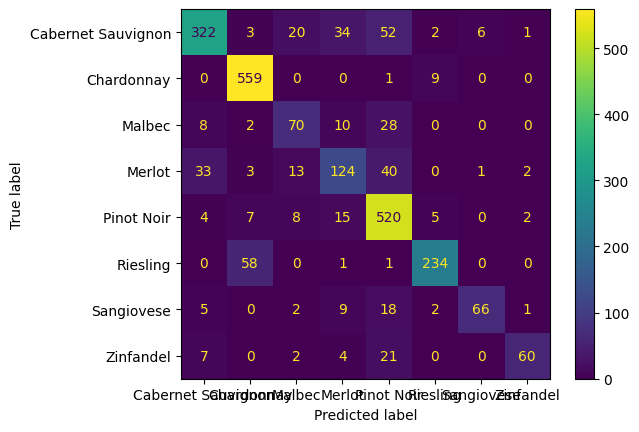

In [25]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(y_val,predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Cabernet Sauvignon" , "Chardonnay","Malbec","Merlot","Pinot Noir","Riesling","Sangiovese","Zinfandel"])

cm_display.plot()
plt.show()